## 1. quality 데이터 수치해석
## 2. XAI 분석
## 3. quality와 error 관계 분석

### 필요 라이브러리 설치

In [16]:
!pip install lime==0.2.0.1

### 학습데이터 로드 및 전처리

In [17]:
#%% 라이브러리 임포트 및 함수 로드
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import math
import datetime as dt
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import *
import sklearn.datasets
import sklearn.ensemble
import lightgbm as lgb
import lime
import lime.lime_tabular
import warnings
from __future__ import print_function
#경고 처리
warnings.filterwarnings(action='ignore')

#matplot 형식
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)
plt.rcParams['axes.unicode_minus'] = False

def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day)

def histo(data): 
    # histogram을 통한 빈도수 계산
    val, cnt = np.unique(data, return_counts=True)
    histo_data_x = np.column_stack((val, cnt))
    histo_data_x = pd.DataFrame(histo_data_x)
    histo_data_x.columns = ['val', 'cnt']
    return(histo_data_x)

def num_qual_delta(crt_qual):
    # 각 quality 데이터 값의 변화량 확인
    count = 0
    for i in range(0,len(crt_qual)-1):
        if not crt_qual.values[i+1] == crt_qual.values[i]:
            if crt_qual.values[i+1] > crt_qual.values[i]:
                count+=1
    return(count)


In [18]:
data_path = 'data/'

train_err  = pd.read_csv(data_path+'train_err_data.csv')
train_qual  = pd.read_csv(data_path+'train_quality_data.csv')
train_prob = pd.read_csv(data_path+'train_problem_data.csv')
train_qual.replace(",", "", regex=True, inplace=True)

In [19]:
#nan 값을 포함한 row 제거
train_err = train_err.dropna(axis=0)
train_qual = train_qual.dropna(axis=0)

#중복제거
qual_idx = train_qual.drop_duplicates(['user_id'], keep='first')['user_id']
isin_filter = train_err['user_id'].isin(qual_idx)
train_err = train_err[isin_filter]

train_err["time"] = train_err["time"].apply(make_datetime)
train_qual["time"] = train_qual["time"].apply(make_datetime)

### Quality 분포 확인

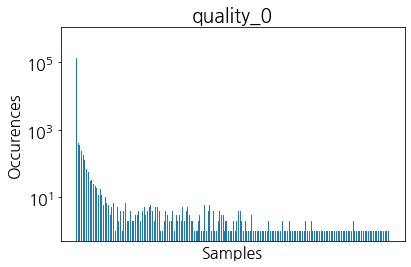

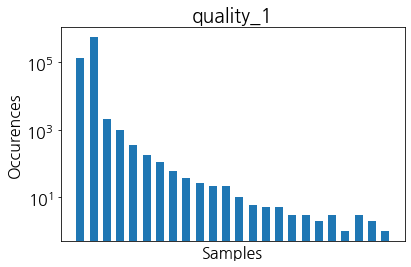

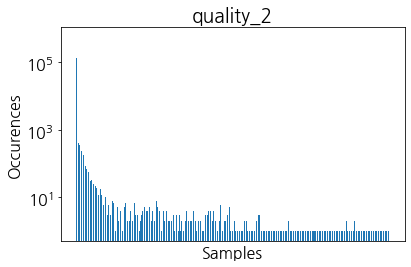

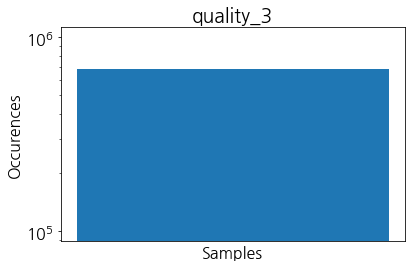

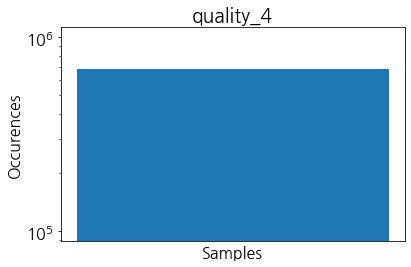

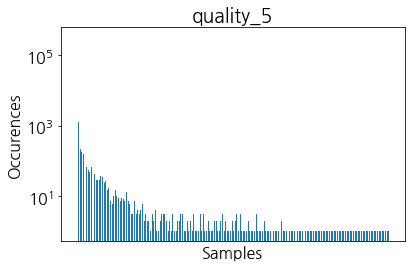

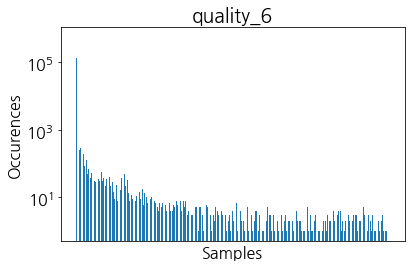

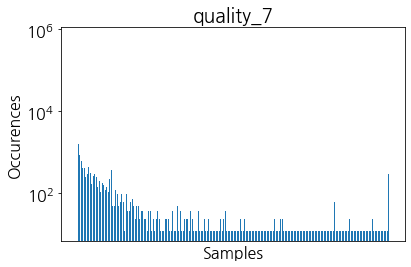

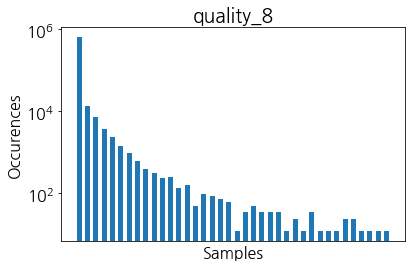

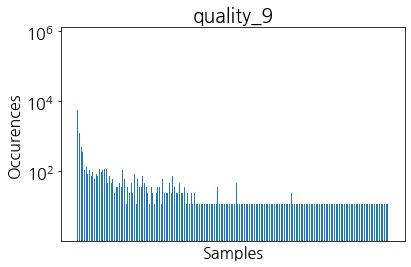

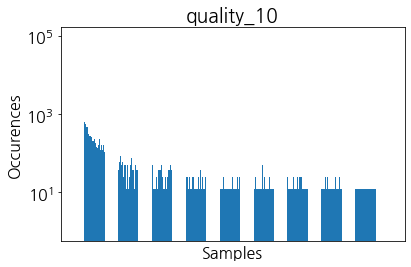

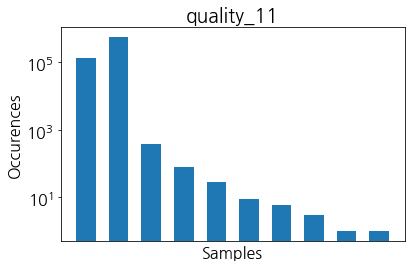

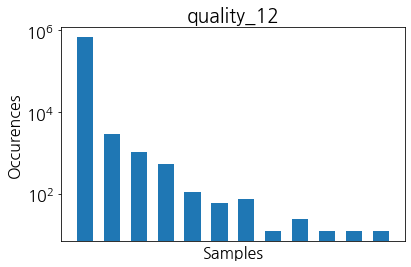

<Figure size 432x288 with 0 Axes>

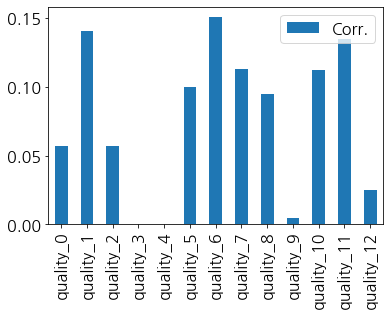

In [20]:
def qual_histo_corr(train_err, train_qual, train_prob):
    col_train_qual = train_qual.columns
    
    histo_list = []
    min_max_list = []
    df_qual_list = []
    
    each_index_qual = train_qual[col_train_qual[1]]
    for i in range(3, len(col_train_qual)):
        # str ',' 제거
        each_chk_qual = train_qual[col_train_qual[i]].astype(str)
        each_chk_qual = each_chk_qual.str.replace(',','')
        each_chk_qual = each_chk_qual.astype(float)
        each_unique = np.unique(each_chk_qual)
        each_max = np.max(each_unique)
        each_min = np.min(each_unique)
        
        each_histo = histo(each_chk_qual)
        histo_list.append(each_histo)
        min_max_list.append([each_max, each_min])
        
        tmp_df = pd.concat([each_index_qual, each_chk_qual], axis=1)
        df_qual_list.append(tmp_df)
    
    # 각 퀄리티에 관한 히스토그램 plot
    for i in range(len(histo_list)):
        crt_histo = histo_list[i]
        x = range(len(crt_histo['cnt']))
        plt.figure()
        plt.title(col_train_qual[3+i])
        plt.bar(x,crt_histo['cnt'], width=0.6, log=True)
        # plt.xticks(x, crt_histo['val'], rotation=45)
        plt.xticks([]) # xticks 생략
        plt.xlabel("Samples")
        plt.ylabel("Occurences")
        plt.tight_layout()
        # plt.savefig('quality_'+str(i)+'.png',dpi=100)
        plt.show()
    
    # 각 퀄리티의 차이값 리스트 생성
    tot_qual_list = []
    for i in range(len(df_qual_list)):
        delta_qual_list = []
        index_unique = np.unique(each_index_qual)
        crt_qual = df_qual_list[i]
        for ii in range(len(index_unique)):
            tmp_qual = crt_qual[crt_qual['user_id'] ==index_unique[ii]]
            delta_value = num_qual_delta(tmp_qual[col_train_qual[3+i]])
            
            delta_qual_list.append([index_unique[ii], delta_value])
        df_delta_qual_list = pd.DataFrame(delta_qual_list)
        df_delta_qual_list.columns = ['user_id', 'value']
        tot_qual_list.append(df_delta_qual_list)
    
    # Make train_y
    user_info = np.unique(train_err['user_id'])
    
    data_idx = np.arange(10000, max(train_err['user_id'])+1)
    df_y = pd.DataFrame([])
    df_y['user_id'] = data_idx
    df_y['value'] = 0
    freq_prob = train_prob.groupby(['user_id']).count()
    
    tmp_idx = freq_prob.index
    tmp_value = freq_prob['time']
    for j in range(0, len(tmp_value)):
        filter_id = df_y['user_id']==tmp_idx[j]
        df_y['value'][filter_id] = tmp_value.values[j]
    
    # Make train_y_compare
    y_compare_list = []
    data_idx = np.arange(10000, max(train_err['user_id'])+1)
    for jj in range(len(tot_qual_list)):
        crt_qual = tot_qual_list[jj]
        # freq_qual = crt_qual.groupby(['user_id']).count()
        tmp_idx = crt_qual['user_id']
        tmp_value = crt_qual['value']
        
        df_y_compare = pd.DataFrame([])
        df_y_compare['user_id'] = data_idx
        df_y_compare['value'] = 0
        
        for j in range(0, len(tmp_value)):
            filter_id = df_y_compare['user_id']==tmp_idx[j]
            df_y_compare['value'][filter_id] = tmp_value.values[j]
        y_compare_list.append(df_y_compare)
    
    #상관관계: problem data, quality data
    qual_corr_list = []
    for i in range(len(y_compare_list)):
        crt_y_compare = y_compare_list[i]
        corr_fin = np.corrcoef(df_y['value'].values, crt_y_compare['value'].values) # user 15000개(tot) 비교 0.1963 
        qual_corr_list.append(corr_fin[0,1])
    df_corr_qual = pd.DataFrame(qual_corr_list)
    df_corr_qual.columns = ['Corr.']
    df_corr_qual = df_corr_qual.T
    df_corr_qual.columns = col_train_qual[3:len(col_train_qual)]
    df_corr_qual = df_corr_qual.T
    
    plt.figure()
    df_corr_qual.plot.bar()
    plt.show()    

qual_histo_corr(train_err, train_qual, train_prob)

### 버전에 따른 quality 평균 (통계량) -- 둘째자리까지만 판단 (model_nm과 동일)

In [21]:
# -1은 분리
minus_1_idx = np.any(train_qual == -1, axis=1)

train_qual_minus_1 = train_qual.loc[minus_1_idx,:].reset_index(drop = True)
train_qual_minus1_excluded = train_qual.loc[~minus_1_idx,:].reset_index(drop = True)
# 둘째자리까지만 남김
train_qual_minus_1['fwver'] = [s[:5] for s in train_qual_minus_1['fwver'].values.astype(str)]
train_qual_minus1_excluded['fwver'] = [s[:5] for s in train_qual_minus1_excluded['fwver'].values.astype(str)]

<Figure size 432x288 with 0 Axes>

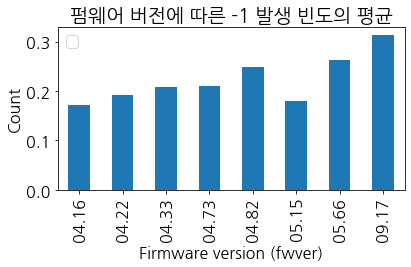

In [22]:
# minus 1 count
minum_1_count = dict()

fwver_2 = train_qual['fwver'] = [s[:5] for s in train_qual['fwver'].values.astype(str)]
fwvers = np.unique(fwver_2)
for fwver in fwvers:
    idx = np.array(fwver_2) == fwver
    counts = train_qual.loc[idx,'quality_0'] == -1
    minum_1_count[fwver] = counts.mean()

# plot
plt.figure(figsize=(6,4))
minum_1_count= pd.DataFrame(minum_1_count,index = [1])
minum_1_count.T.plot.bar()
plt.ylabel("Count")
plt.xlabel("Firmware version (fwver)")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.title('펌웨어 버전에 따른 -1 발생 빈도의 평균')
plt.legend([])
plt.tight_layout()
# plt.savefig('qual_minus_1.png')
plt.show()

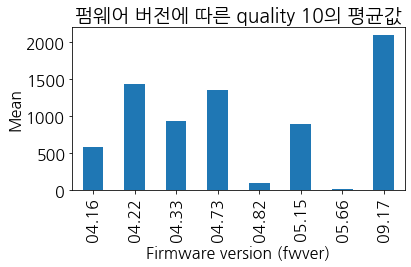

In [23]:
fwvers = np.unique(train_qual_minus1_excluded['fwver'])
mean_dict = dict()
for fwver in fwvers:
    idx = train_qual_minus1_excluded['fwver'] == fwver
    mean_dict[fwver] = np.nanmean(train_qual_minus1_excluded.loc[idx,'quality_0':'quality_12'].astype(float), axis=0)

mean_dict= pd.DataFrame(mean_dict)
mean_dict.iloc[10,:].plot.bar()
plt.xlabel('Firmware version (fwver)')
plt.ylabel('Mean')
plt.title('펌웨어 버전에 따른 quality 10의 평균값')
plt.tight_layout()
# plt.savefig('펌웨어 버전에 따른 quality 평균값_10.png')
plt.show()

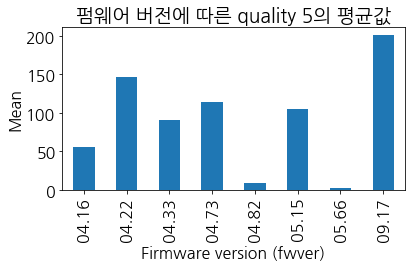

In [24]:
mean_dict= pd.DataFrame(mean_dict)
mean_dict.iloc[5,:].plot.bar()
plt.xlabel('Firmware version (fwver)')
plt.ylabel('Mean')
plt.title('펌웨어 버전에 따른 quality 5의 평균값')
plt.tight_layout()
# plt.savefig('펌웨어 버전에 따른 quality 평균값_5.png')
plt.show()

### quality 통계적 수치

In [25]:
unique_user_id = np.unique(train_qual_minus1_excluded['user_id'])
qual_s_mean = np.zeros((len(unique_user_id), 13))
for i, user_id in enumerate(unique_user_id):
    idx = train_qual_minus1_excluded['user_id'] == user_id
    qual_s_mean[i,:] = np.nanmean(train_qual_minus1_excluded.loc[idx, 'quality_0':'quality_12'].astype(float), axis=0)
    
unique_user_id = np.unique(train_qual_minus1_excluded['user_id'])
qual_s_max = np.zeros((len(unique_user_id), 13))
for i, user_id in enumerate(unique_user_id):
    idx = train_qual_minus1_excluded['user_id'] == user_id
    qual_s_max[i,:] = np.nanmax(train_qual_minus1_excluded.loc[idx, 'quality_0':'quality_12'].astype(float), axis=0)
    
unique_user_id = np.unique(train_qual_minus1_excluded['user_id'])
qual_s_std = np.zeros((len(unique_user_id), 13))
for i, user_id in enumerate(unique_user_id):
    idx = train_qual_minus1_excluded['user_id'] == user_id
    qual_s_std[i,:] = np.nanstd(train_qual_minus1_excluded.loc[idx, 'quality_0':'quality_12'].astype(float), axis=0)

In [26]:
print('==평균==')
for i in range(13):
    print(i)
    print('{:.3f}'.format(np.mean(qual_s_mean[:,i])))
print('==최대==')
for i in range(13):
    print(i)
    print('{:.3f}'.format(np.mean(qual_s_max[:,i])))
print('==variance==')
for i in range(13):
    print(i)
    print('{:.3f}'.format(np.mean(qual_s_std[:,i])))

==평균==
0
12.077
1
0.021
2
12.090
3
0.000
4
0.000
5
103.427
6
3.056
7
30.032
8
0.151
9
36.901
10
859.638
11
0.002
12
0.008
==최대==
0
95.258
1
0.351
2
96.799
3
0.000
4
0.000
5
1417.345
6
30.925
7
78.481
8
0.459
9
204.928
10
3300.020
11
0.034
12
0.040
==variance==
0
13.674
1
0.061
2
13.817
3
0.000
4
0.000
5
228.288
6
6.595
7
22.129
8
0.125
9
55.807
10
911.996
11
0.004
12
0.010


In [27]:
unique_user_id = np.unique(train_qual_minus_1['user_id'])
qual_minus_1_count = np.zeros((len(unique_user_id), 13))
for i, user_id in enumerate(unique_user_id):
    idx = train_qual_minus_1['user_id'] == user_id
    qual_minus_1_count[i,:] = np.nansum(train_qual_minus_1.loc[idx, 'quality_0':'quality_12'].astype(float) == -1, axis=0)

In [28]:
print('최댓값')
print(np.max(qual_minus_1_count, axis=0))
print('평균값')
print(np.mean(qual_minus_1_count, axis=0))

최댓값
[1273. 1273. 1273.    0.    0. 1273. 1273.    0.    0.    0.    0. 1273.
    0.]
평균값
[23.50044907 23.50026944 23.50044907  0.          0.         23.50044907
 23.50026944  0.          0.          0.          0.         23.50026944
  0.        ]


### Quality간 상관관계

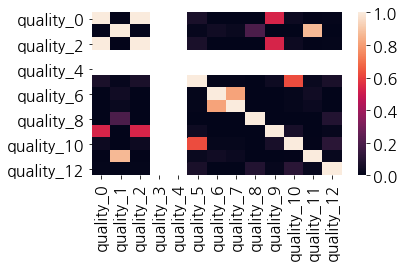

In [29]:
#%% Quality 간 상관관계
def quality_corr(train_qual):
    col_train_qual = train_qual.columns
    crt_qual = train_qual[col_train_qual[3:len(col_train_qual)]]
    
    tmp_qual = crt_qual.astype(str)
    #전처리(, 제거)
    tmp_qual = tmp_qual[col_train_qual[3:len(col_train_qual)]]
    tmp_qual = tmp_qual.apply(lambda x: x.str.replace(',',''), axis = 1)
    tmp_qual = tmp_qual.astype(float)
    df_qual_corr = tmp_qual.corr()
    #plot
    plt.figure()
    sns.heatmap(df_qual_corr, annot = False, vmin=0, vmax=1)
    plt.tight_layout()
    # plt.savefig('corr_heatmap.png')
    plt.show()

quality_corr(train_qual)

### Lime 분석

In [42]:
def separated_data(data_idx, tmp_idx):
    non_label_list= []
    for i in range(len(data_idx)):
        crt_idx = data_idx[i]
        if not crt_idx in tmp_idx:
            non_label_list.append(crt_idx)
    return(non_label_list)        

def f_pr_auc(probas_pred, y_true):
    labels = y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score = auc(r, p)
    return "pr_auc", score, True


def train_model(train_x, train_y, params, col_x_names):
    '''
    cross validation with given data
    '''
    models = []
    valid_probs = np.zeros((train_y.shape[0], 2))
    # valid_probs = np.zeros((train_y.shape))
    valid_x_set = np.zeros((train_x.shape))
    # -------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_idx, val_idx in k_fold.split(train_x):
        # split train, validation set
        X = train_x[train_idx,:]
        y = train_y[train_idx]
        valid_x = train_x[val_idx,:]
        valid_y = train_y[val_idx]

        # split train, validation set
        X = pd.DataFrame(train_x[train_idx,:])
        y =  pd.DataFrame(train_y[train_idx])
        valid_x =  pd.DataFrame(train_x[val_idx,:])
        valid_y =  pd.DataFrame(train_y[val_idx])

        #데이터프레임 정리(컬럼 명 생성 및 적용)
        target_names = "Y_target"
        X.columns = col_x_names
        valid_x.columns = col_x_names
        y.columns = [target_names]
        valid_y.columns = [target_names]

        model = lgb.LGBMClassifier(**params)
        model.fit(X, y, eval_set=[(valid_x, valid_y)], 
                  early_stopping_rounds = 100,
                  verbose=100)

        # cal valid prediction
        valid_prob = model.predict_proba(valid_x)
        valid_probs[val_idx,:] = valid_prob
        valid_x_set[val_idx] = valid_x
        models.append(model)
        print("iteration!!!!!!!!!!!!!!!")

    return models, valid_probs, train_x, X, valid_x_set

#%% XAI_LIME - model training

def x_al_model(train_err_r1, train_prob):
  # X
  col_x_names = train_err_r1.columns 
  train_err_r = train_err_r1.values 
  # y
  train_y = np.zeros(15000)
  train_y[train_prob.user_id.unique()-10000] = 1 

  params = {
      'n_estimators' : 1000,
      'boosting_type': 'gbdt',
      'objective' : 'binary',
      'metric': 'auc',
      'max_depth': -1,
      'seed': 1015,}


  # 모델 학습
  models, valid_probs, train_x, X, valid_x_set = train_model(train_err_r, train_y, params, col_x_names)

  # evaluate
  threshold = 0.5
  valid_preds = np.where(valid_probs > threshold, 1, 0)
  valid_preds = valid_preds[:,1]

  # cal scores
  recall = recall_score(train_y, valid_preds)
  precision = precision_score(train_y, valid_preds)
  auc_score = roc_auc_score(train_y, valid_probs[:,1])
  print(auc_score)
  return (models, valid_probs, train_x, X, valid_x_set)

from main import feature_extraction

train_err1  = pd.read_csv(data_path+'train_err_data.csv')
train_qual1  = pd.read_csv(data_path+'train_quality_data.csv')

train_err_r1 = feature_extraction('train', train_err1, train_qual1)
models, valid_probs, train_x, X, valid_x_set = x_al_model(train_err_r1, train_prob)



Splitting error data in day...


  0%|                                                                                                                                                                                              | 6/15000 [00:00<04:41, 53.24it/s]

Splitting error data in day is done
Extract features from error...


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 12435/15000 [04:03<00:43, 58.85it/s]

UNKNOWN error code for type 5 :: http


  1%|█▋                                                                                                                                                                                         | 134/15000 [00:00<00:22, 665.03it/s]

Extract features from error is done
Extract features from model...


  1%|█▌                                                                                                                                                                                         | 130/15000 [00:00<00:23, 637.83it/s]

Extract features from model is done
Extract features from fwver...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:29<00:00, 501.62it/s]


Extract features from fwver is done
Extract features from quality...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7727/7727 [01:37<00:00, 78.95it/s]


Extract features from quality is done
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.843481
Early stopping, best iteration is:
[43]	valid_0's auc: 0.847099
iteration!!!!!!!!!!!!!!!
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.831728
Early stopping, best iteration is:
[64]	valid_0's auc: 0.832762
iteration!!!!!!!!!!!!!!!
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.840194
Early stopping, best iteration is:
[76]	valid_0's auc: 0.842377
iteration!!!!!!!!!!!!!!!
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.825252
Early stopping, best iteration is:
[52]	valid_0's auc: 0.826974
iteration!!!!!!!!!!!!!!!
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.834472
Early stopping, best iteration is:
[56]	valid_0's auc: 0.836866
iteration!!!!!!!!!!!!!!!
0.8371275200000001


In [43]:
#X_AI Lime - application and analysis

# explainer = lime.lime_tabular.LimeTabularExplainer(train_x, feature_names=col_x_names.T, class_names="Y_target", discretize_continuous=False) # "Y_target"
explainer = lime.lime_tabular.LimeTabularExplainer(train_x, discretize_continuous=True)

#for model_n in range(len(models)):
model_n = 4
gbtree = models[model_n]

predict_fn = lambda x: gbtree.predict_proba(valid_x_set).astype(float)
np.random.seed(1)
i = 100

exp = explainer.explain_instance(valid_x_set[i], gbtree.predict_proba, num_features=30)
exp.show_in_notebook(show_all=False)

feature_index = 57

temp = valid_x_set[i].copy()
print('Original value : ', temp[feature_index, ])
print('P(before) :', gbtree.predict_proba(temp.reshape(1,-1))[0,1])

temp[feature_index, ] = 30
print('Change value : ', temp[feature_index, ])
print('P(after) :', gbtree.predict_proba(temp.reshape(1,-1))[0,1])

Original value :  0.0
P(before) : 0.3849882016659979
Change value :  30.0
P(after) : 0.3849882016659979


In [44]:
col_x_names = pd.DataFrame(train_err_r1.columns)
col_x_names.T

,0,1,2,3,4,5,6,7,8,9,...,764,765,766,767,768,769,770,771,772,773
0,errorcode_1-0_min,errorcode_1-P_min,errorcode_10-1_min,errorcode_11-1_min,errorcode_12-1_min,errorcode_13-1_min,errorcode_14-1_min,errorcode_14-13_min,errorcode_14-14_min,errorcode_15-1_min,...,quality_10_med,quality_10_std,quality_11_mean,quality_11_max,quality_11_med,quality_11_std,quality_12_mean,quality_12_max,quality_12_med,quality_12_std


### quality와 error data 관계 분석

In [45]:
def entropy_extraction(train_qual):
    col_qual = train_qual.columns
    
    gruoped_qual_time = dict(list( train_qual.groupby("time") ))
    grouped_qual_time_key= list(gruoped_qual_time.keys())
    grouped_qual_time_value= list(gruoped_qual_time.values())
    
    user_entr_tot_list = []
    for iii in range(len(grouped_qual_time_value)):
    
        crt_grouped_qual_time = grouped_qual_time_value[iii]
        
        crt_gropued_qual_time_user = dict(list( crt_grouped_qual_time.groupby("user_id") ))
        crt_gropued_qual_time_user_key = list(crt_gropued_qual_time_user.keys())
        crt_gropued_qual_time_user_value = list(crt_gropued_qual_time_user.values())
        
        user_entr_list = []
        for ii in range(len(crt_gropued_qual_time_user_value)):
            tmp_gropued_qual_time_user_value = crt_gropued_qual_time_user_value[ii]
            
            user_entr = tmp_gropued_qual_time_user_value[col_qual[0:3]][:1]
            user_entr = user_entr.reset_index()
            del user_entr['index']
            for i in range(3,len(col_qual)):
                tmp_quality = tmp_gropued_qual_time_user_value[col_qual[i]]
                tmp_quality = tmp_quality.astype(str)
                tmp_quality = tmp_quality.str.replace(',','')
                tmp_quality = tmp_quality.astype(float)
                tmp_quality += 1
                tmp_quality = tmp_quality.values[0:int(len(tmp_quality)/12)*12]
                tmp_quality = tmp_quality.reshape(12,-1)
                tmp_lambda = 1/(tmp_quality.mean())
                tmp_entr = 1 - math.log(tmp_lambda)
                tmp_entr = pd.Series(tmp_entr, name=col_qual[i]) 
                user_entr = pd.concat([user_entr, tmp_entr], axis=1)
            user_entr_list.append(user_entr)
        
        df_user_entr = user_entr_list[0]
        for j in range(1, len(user_entr_list)):
            df_user_entr = pd.concat([df_user_entr, user_entr_list[j]])
        
        user_entr_tot_list.append(df_user_entr)
    
    df_user_entr_tot = user_entr_tot_list[0]
    for j in range(1, len(user_entr_tot_list)):
        df_user_entr_tot = pd.concat([df_user_entr_tot, user_entr_tot_list[j]])
    return (df_user_entr_tot)
    
df_user_entr_tot = entropy_extraction(train_qual)

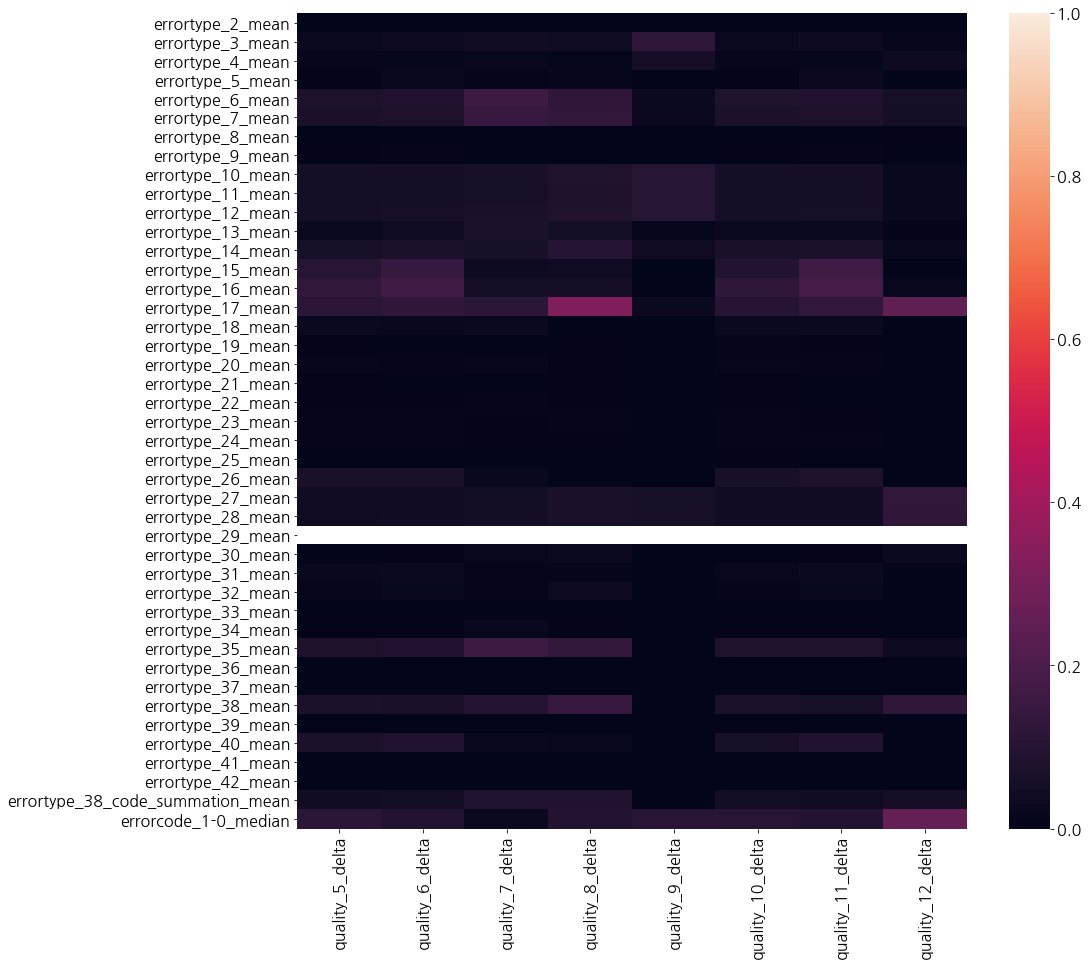

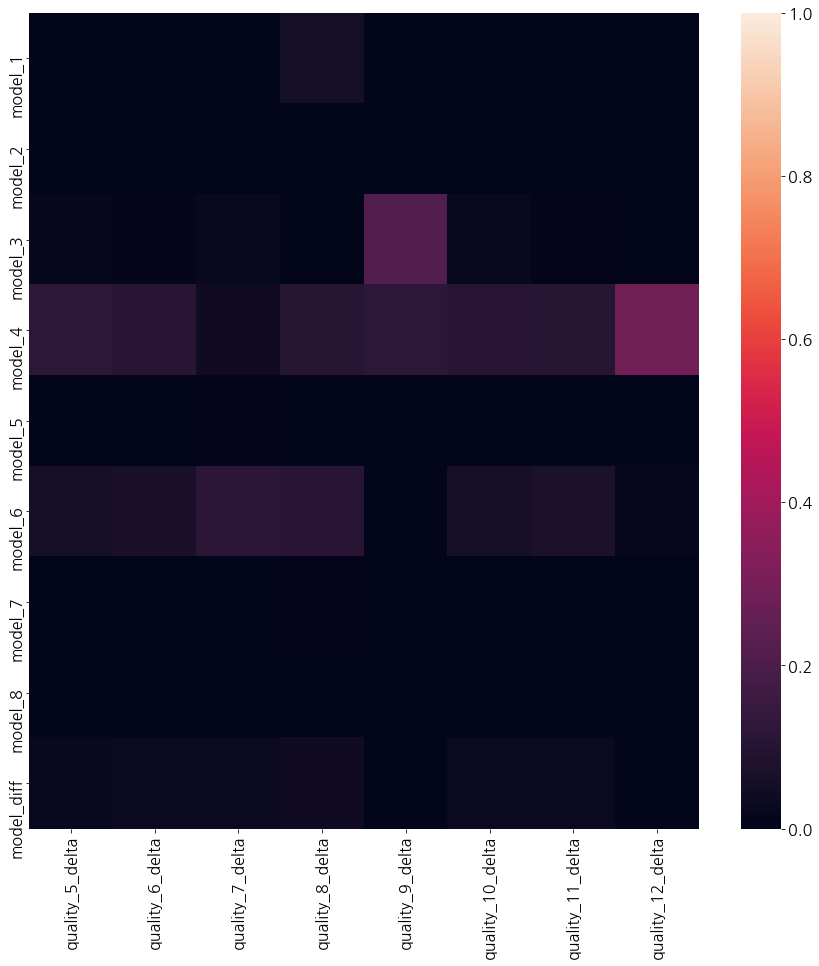

In [49]:
#%% 엔트로피 변화량 있는지
def entropy_delta(train_qual):
    col_qual = train_qual.columns
    
    gruoped_entr_user = dict(list( df_user_entr_tot.groupby("user_id") ))
    gruoped_entr_user_key = pd.DataFrame(list(gruoped_entr_user.keys()))
    gruoped_entr_user_key.columns = ["user_id"]
    gruoped_entr_user_value = list(gruoped_entr_user.values())
    
    df_entr_delta = pd.DataFrame([])
    
    for i in range(len(gruoped_entr_user_value)):
        crt_grouped_entr_user = gruoped_entr_user_value[i][col_qual[3:len(col_qual)]]
        crt_grouped_entr_user_mean = crt_grouped_entr_user.mean(axis=0)
        crt_grouped_entr_user_first_row = crt_grouped_entr_user.iloc[0]
        crt_grouped_entr_user_delta = crt_grouped_entr_user_first_row - crt_grouped_entr_user_mean
        crt_grouped_entr_user_delta = pd.DataFrame(np.where(crt_grouped_entr_user_delta==0,0,1)).T
        col_name_delta = col_qual[3:len(col_qual)] +"_delta"
        crt_grouped_entr_user_delta.columns = col_name_delta
        
        df_entr_delta = pd.concat([df_entr_delta, crt_grouped_entr_user_delta], axis=0)
    
    df_entr_delta = df_entr_delta.reset_index()
    del df_entr_delta['index']
    
    df_entr_delta = pd.concat([gruoped_entr_user_key, df_entr_delta],axis=1)
    
    user_id = train_err.drop_duplicates(['user_id'], keep='first')['user_id']
    user_id = user_id.reset_index()
    del user_id['index']
    
    df_entr_delta_tot = pd.merge(df_entr_delta, user_id, on="user_id", how="outer")
    df_entr_delta_tot = df_entr_delta_tot.fillna(0)
    df_entr_delta_tot = df_entr_delta_tot.sort_values(by="user_id")
    df_entr_delta_tot = df_entr_delta_tot.reset_index()
    del df_entr_delta_tot['index']
    
    return (df_entr_delta_tot)

df_entr_delta_tot = entropy_delta(train_qual)

#%% 에러 feature와 Quality 엔트로피 관계성 분석

def Heatmap_err_qual_entropy(a1, a2):

    col_a1 = a1.columns
    col_a2 = a2.columns
    
    tmp_concat = pd.concat([a1, a2], axis=1)
    corr_concat = tmp_concat.corr()
    
    corr_part = corr_concat[col_a1]
    corr_part = corr_part.loc[col_a2]
    
    plt.figure(figsize=(15,15))
    sns.heatmap(corr_part, annot = False, vmin=0, vmax=1) 
    


train_err_features = train_err_r1.copy() #파일 생성으로 변경해야함
col_train_err_features = train_err_features.columns

train_err_features_idx = train_err_features[col_train_err_features[0:1]]
train_err_features_idx.columns = ['user_id']

# error type mean
train_err_features_err_mean = train_err_features[col_train_err_features[381:424]] 
train_err_features_err_mean = pd.concat([train_err_features_idx, train_err_features_err_mean], axis=1)
train_err_features_err_mean = train_err_features_err_mean.fillna(0)

a1 = df_entr_delta_tot[df_entr_delta_tot.columns[6:len(df_entr_delta_tot)]]
a2 = train_err_features_err_mean[train_err_features_err_mean.columns[1:len(train_err_features_err_mean)]]

Heatmap_err_qual_entropy(a1, a2)

# model nm
train_err_features_err_mean = train_err_features[col_train_err_features[706:715]] 
train_err_features_err_mean = pd.concat([train_err_features_idx, train_err_features_err_mean], axis=1)
train_err_features_err_mean = train_err_features_err_mean.fillna(0)

a1 = df_entr_delta_tot[df_entr_delta_tot.columns[6:len(df_entr_delta_tot)]]
a2 = train_err_features_err_mean[train_err_features_err_mean.columns[1:len(train_err_features_err_mean)]]

Heatmap_err_qual_entropy(a1, a2)

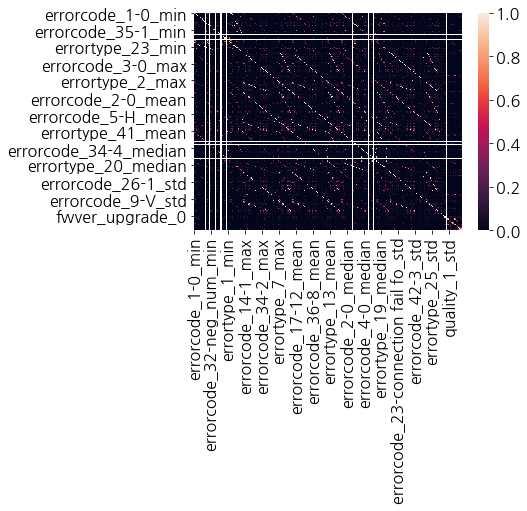

In [51]:
train_err_features1 = train_err_r1 #파일 생성으로 변경해야함
corr_features = train_err_features1.corr()

plt.figure()
sns.heatmap(corr_features, annot = False, vmin=0, vmax=1) 
plt.show()